# k8s Experiment Results

In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

def calculate_qoe_from_csv(filename, scaler=None):
  qoe_df = pd.read_csv(filename)
  # qoe_df = qoe_df.loc[qoe_df["user"] < 10]
  
  #Set Min and Max for Each Data Values
  min_row = pd.DataFrame([[999,0.0,0.0,300,0.0,300,-9999.781301,1.0,3,150]], columns = qoe_df.columns)
  # max_row = pd.DataFrame([[999,800.0,999.0,20000,1.0,150000.969951,-9999.781301,1.0,3,150]], columns = qoe_df.columns)
  qoe_df = pd.concat([qoe_df,min_row], ignore_index=True)  
  cpu = qoe_df['cpu'].copy()
  user = qoe_df['user'].copy()
  stall_duration = qoe_df['avg_stall_duration']
  qoe_df.drop(columns=["client_id", "qoe", "watch_time", 'cpu', 'user', 'avg_stall_duration'], inplace=True)
  qoe_df['video_resolution'] = qoe_df['video_resolution'].apply(lambda x: min(700,x))
  qoe_df['media_loading_duration'] = qoe_df['media_loading_duration'].apply(lambda x: max(30000, x))
  scaler = MinMaxScaler() if scaler == None else scaler
  scaled_qoe_df = scaler.fit_transform(qoe_df)
  scaled_qoe_df = pd.DataFrame(scaled_qoe_df, columns=qoe_df.columns)
  scaled_qoe_df['cpu'] = cpu
  scaled_qoe_df['user'] = user
  scaled_qoe_df['avg_stall_duration'] = stall_duration
  # scaled_qoe_df['qoe'] = scaled_qoe_df['video_resolution'] * (1- 1.0*(scaled_qoe_df['media_loading_duration'] + 0*scaled_qoe_df['startup_delay'])) - 0.01*scaled_qoe_df['variation_rate'] - 0.5*scaled_qoe_df['avg_stall_duration'] 
  scaled_qoe = 0.5 * scaled_qoe_df['video_resolution'] - 0.35*(scaled_qoe_df['media_loading_duration'] + 0*scaled_qoe_df['startup_delay']) - 0.05*scaled_qoe_df['variation_rate'] - 0.1*scaled_qoe_df['avg_stall_duration'] 
  scaled_qoe = scaled_qoe.apply(lambda x: max(0,x))
  qoe_scaler = MinMaxScaler()
  print(scaled_qoe.shape)
  scaled_qoe_df['qoe'] = qoe_scaler.fit_transform(scaled_qoe.values.reshape(-1,1))
  # scaled_qoe_df = scaled_qoe_df.loc[scaled_qoe_df['avg_stall_duration'] < 0.9]
  scaled_qoe_df = scaled_qoe_df.loc[scaled_qoe_df['user'] < 10]  
  return scaled_qoe_df, scaler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

# Define the generalized logistic function with user-dependent parameters
def generalized_logistic(X, L, alpha, beta_0, beta_CPU, beta_CPU_squared, beta_users, beta_interaction, n_users,atk):
    # Logistic function calculation with the specified regression equation
    if atk == "none":
        # L = L*(1-alpha*n_users)
        L = 0.95
        # beta_users = -0.3
        # beta_interaction = -0.5 
    else:
        L = L*(1-alpha*n_users)    
    linear_combination = (
        beta_0 
        + beta_CPU * X 
        # + beta_CPU_squared * (X ** 2) 
        + beta_users* n_users 
        # + beta_interaction * (X * n_users) #Makes it Steepness Decrease
    )

    # return L*(1-alpha*n_users) / (1 + np.exp(-linear_combination))
    return 0.95 / (1 + np.exp(-linear_combination))

def get_fit_params_all(scaled_qoe_df, atk):
    mean_qoe_by_cpu = scaled_qoe_df.groupby("cpu")[["user","qoe"]].mean().reset_index()
    cpu = mean_qoe_by_cpu["cpu"]
    y = mean_qoe_by_cpu["qoe"]
    n_user = mean_qoe_by_cpu['user']
    
    # cpu = scaled_qoe_df['cpu']
    # y = scaled_qoe_df['qoe']
    # n_user = scaled_qoe_df['user']
    
    # Lambda function for fitting, including n_user as a parameter
    fit_func = lambda cpu, L, alpha, beta_0, beta_CPU, beta_CPU_squared, beta_users, beta_interaction: generalized_logistic(
        cpu, L, alpha, beta_0, beta_CPU, beta_CPU_squared, beta_users, beta_interaction, n_user, atk=atk)
    
    # Fit the generalized logistic function
    params, _ = curve_fit(
        fit_func, cpu, y, 
        p0=[0.8,0, 0, 1, 0, 0.1, 0],  # Initial guesses for parameters
        bounds=([0, 0, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf], [1, 1, np.inf, np.inf, np.inf, np.inf, np.inf])
    )
    return params

# Function for plotting marginal bars
def plot_marginal_bar(x, y, ax):
    bin_edges = np.arange(0, 1, 0.03)
    for cpu in np.arange(0.5, 6.5, 0.5):
        curr_cpu_idx = np.where(x == cpu)
        curr_y = y[curr_cpu_idx]
        hist, _ = np.histogram(curr_y, bins=bin_edges)
        ax.barh(bin_edges[:-1], hist / 10, height=0.03, left=cpu - 0.05, color='gray', alpha=0.7)

# Main function to plot QoE
def plot_qoe(scaled_qoe_df, atk="none",plot=True):
    num_users = 6

    # Set up a figure with subplots
    if plot:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Density Map of QoE vs CPU for Users 1 to 6')

    cpu_fit = np.linspace(0.5, 8.0, 100)  # Range of CPU values for plotting the fit
    params = get_fit_params_all(scaled_qoe_df,atk)
    
    for n_user in range(1, num_users + 1):
        
        filtered_qoe_df = scaled_qoe_df.loc[scaled_qoe_df['user'] == n_user]
        x = filtered_qoe_df['cpu'].fillna(0).values
        y = filtered_qoe_df['qoe'].fillna(0).values
        mean_qoe_by_cpu = filtered_qoe_df.groupby("cpu")["qoe"].mean().reset_index()

        # Calculate the point density
        xy = np.vstack([x, y])
        density = gaussian_kde(xy)(xy)

        # Calculate fitted QoE values
        qoe_fit = generalized_logistic(cpu_fit, *params, n_user, atk=atk)

        # Plot the logistic fit line
        if plot:
            ax = axes[(n_user - 1) // 3, (n_user - 1) % 3]
            sc = ax.scatter(x, y, c=density, s=density * 200, cmap='seismic', alpha=0.7)
            ax.plot(cpu_fit, qoe_fit, color='black', linestyle='--', label='Logistic Fit')
            ax.plot(mean_qoe_by_cpu["cpu"], mean_qoe_by_cpu["qoe"], color='green', marker="x", linestyle='--', label='Average')
            plot_marginal_bar(x, y, ax)

            ax.set_xlabel('CPU')
            ax.set_ylabel('QoE')
            ax.set_ylim(-0.05, 1.05)
            ax.set_title(f'{n_user} User(s)')
            ax.legend()
    if(plot):
        fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='horizontal', label='Density')
        plt.show()
    return params

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

# Standard logistic function (without user dependency)
def logistic(X, L, beta_0, beta_CPU):
    return 0.97 / (1 + np.exp(-(beta_0 + beta_CPU * X)))

def get_fit_params_all(scaled_qoe_df, atk):
    cpu = scaled_qoe_df['cpu']
    y = scaled_qoe_df['qoe']
    
    # Lambda function for standard logistic fitting (no user dependency)
    fit_func = lambda cpu, L, beta_0, beta_CPU: logistic(cpu, L, beta_0, beta_CPU)
    
    # Fit the logistic function
    params, _ = curve_fit(
        fit_func, cpu, y, 
        p0=[0.8, 0, 1],  # Initial guesses for parameters
        # bounds=([0, -np.inf, -np.inf], [1, np.inf, np.inf])
        bounds=([0, -10, 0], [1, 0, 10])
        
    )
    return params

# Function for plotting marginal bars
def plot_marginal_bar(x, y, ax):
    bin_edges = np.arange(0, 1, 0.03)
    for cpu in np.arange(0.5, 6.5, 0.5):
        curr_cpu_idx = np.where(x == cpu)
        curr_y = y[curr_cpu_idx]
        hist, _ = np.histogram(curr_y, bins=bin_edges)
        ax.barh(bin_edges[:-1], hist / 10, height=0.03, left=cpu - 0.05, color='gray', alpha=0.7)

# Main function to plot QoE
def plot_qoe(scaled_qoe_df, atk="none", plot=True):
    num_users = 6
    cpu_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]
    mean_df = pd.DataFrame()
    # Set up a figure with subplots
    if plot:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Density Map of QoE vs CPU for Users 1 to 6')
    CPU_CAP = 8.0
    cpu_fit = np.linspace(0.5, CPU_CAP, 100)  # Range of CPU values for plotting the fit
    
    for n_user in range(1, num_users + 1):
        # Filter data for the specific user
        filtered_qoe_df = scaled_qoe_df.loc[scaled_qoe_df['user'] == n_user]
        x = filtered_qoe_df['cpu'].fillna(0).values
        y = filtered_qoe_df['qoe'].fillna(0).values
        mean_qoe_by_cpu = filtered_qoe_df.groupby('cpu')['qoe'].mean().reset_index()
        df_pivot = mean_qoe_by_cpu.set_index('cpu').T.reindex(columns=cpu_values)
        mean_df = pd.concat([mean_df, df_pivot], axis=0)
        # Calculate logistic fit parameters for the specific user
        params = get_fit_params_all(mean_qoe_by_cpu, atk)
        # Calculate fitted QoE values based on logistic function
        qoe_fit = logistic(cpu_fit, *params)
        print(f"{n_user},{list(params)}")
        # Plot the logistic fit line
        if plot:
            ax = axes[(n_user - 1) // 3, (n_user - 1) % 3]
            # Density calculation for scatter plot
            xy = np.vstack([x, y])
            density = gaussian_kde(xy)(xy)
            sc = ax.scatter(x, y, c=density, s=density * 200, cmap='seismic', alpha=0.7)
            ax.plot(cpu_fit, qoe_fit, color='black', linestyle='--', label='Logistic Fit')
            ax.plot(mean_qoe_by_cpu["cpu"], mean_qoe_by_cpu["qoe"], color='green', marker="x", linestyle='--', label='Average')
            plot_marginal_bar(x, y, ax)

            ax.set_xlabel('CPU')
            ax.set_ylabel('QoE')
            ax.set_ylim(-0.05, 1.05)
            ax.set_title(f'{n_user} User(s)')
            ax.legend()
    if plot:
        fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='horizontal', label='Density')
        plt.show()
    return mean_df
        

(520,)
1,[0.8, -2.2782437661320376, 4.880185592855777]
2,[0.8, -3.887327194884755, 5.175693282061739]
3,[0.8, -4.495653688640001, 4.080861159236956]
4,[0.8, -3.3377691071239193, 2.543137984376065]
5,[0.8, -4.186922138120784, 2.389328009334868]
6,[0.8, -5.93532097721194, 2.5629823965579503]


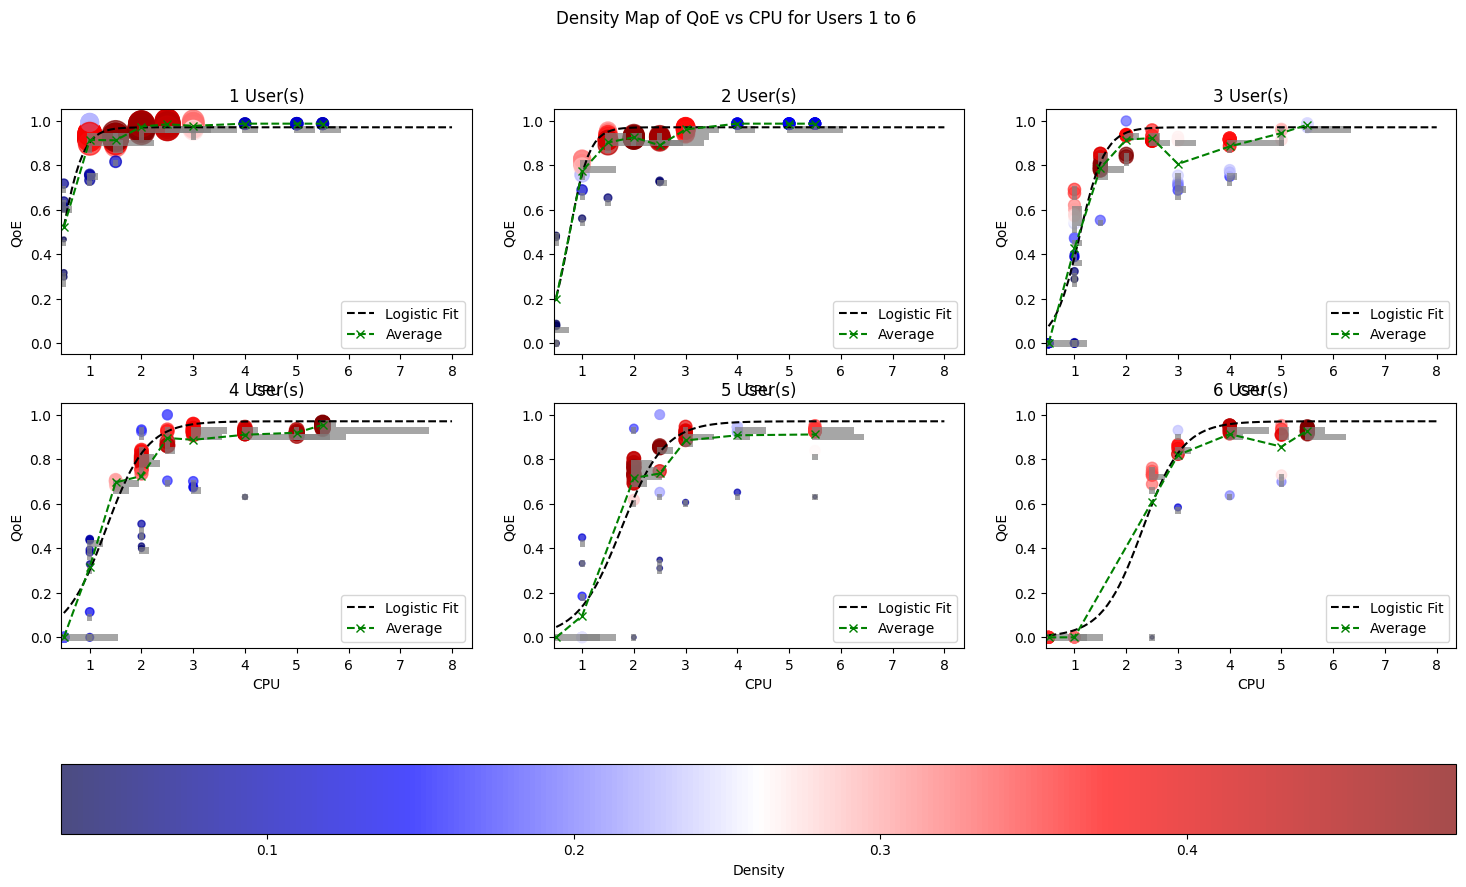

L, alpha, beta_0, beta_CPU, beta_CPU_squared, beta_users, beta_interaction


In [24]:
scaled_qoe_df, scaler = calculate_qoe_from_csv("150_qoe_noatk_noids.csv")
logis_params = plot_qoe(scaled_qoe_df,atk="none")
print("L, alpha, beta_0, beta_CPU, beta_CPU_squared, beta_users, beta_interaction")

# print(list(logis_params))

# for user in range(1,7):
#     curr_df = scaled_qoe_df.loc[scaled_qoe_df["user"] == user]
#     print("user: ", user)
#     print(list(curr_df.groupby("cpu")["qoe"].std().values))

(658,)
1,[0.8, -0.1716553299350621, 0.34879040293629493]
2,[0.8, -1.57074822719627, 0.8426056467362176]
3,[0.8, -3.37667809302616, 2.1758909158437425]
4,[0.8, -2.290421396323277, 0.835511858184773]
5,[0.8, -2.612606954605567, 0.7270722127184464]
6,[0.8, -2.825445303055909, 0.743826007830567]


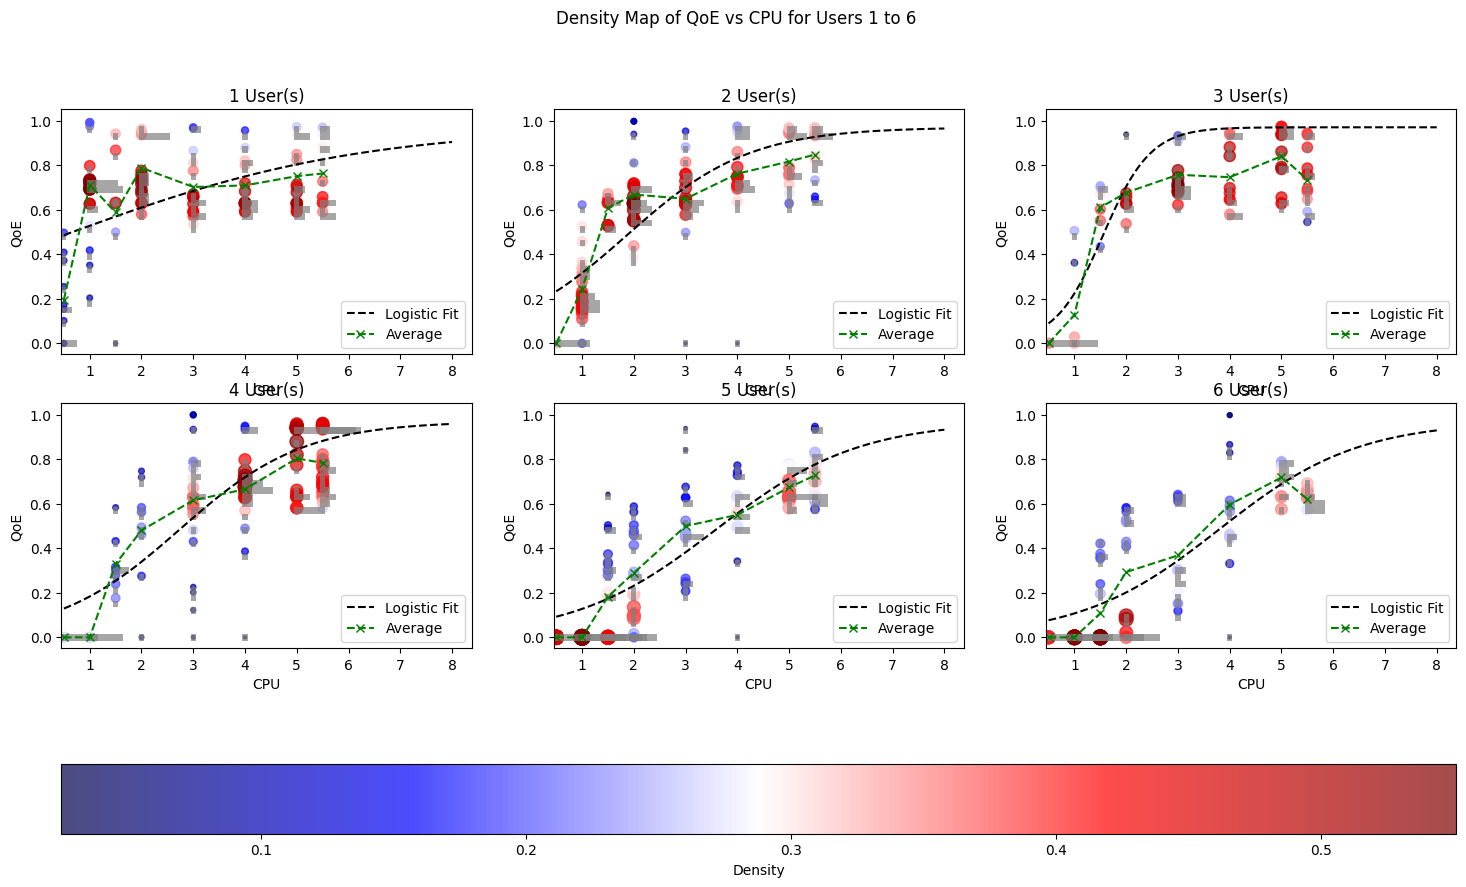

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]
user:  1
[0.18148548574101364, 0.19525845150263352, 0.3735265786050765, 0.13990525889873542, 0.1414290011321135, 0.11646621734564502, 0.14790927291167025, 0.1536122558423542]
user:  2
[0.0, 0.14783862772142903, 0.06194265747260652, 0.17534629124748985, 0.19748232408142152, 0.22524795828741218, 0.13220975996152487, 0.11878029900395902]
user:  3
[0.0, 0.21309737922789193, 0.10474150018336606, 0.13632414292616646, 0.10731761522391847, 0.152219093570187, 0.1385283537617212, 0.13424714886608577]
user:  4
[0.0, 0.0, 0.1253324302044579, 0.24442596061895078, 0.26873089218471863, 0.19010650872747845, 0.16100026703545423, 0.13573308612388368]
user:  5
[0.0, 0.0, 0.2112452237841777, 0.20040473514234383, 0.21612136868495996, 0.18814779214681668, 0.07131386804048287, 0.1203538824183219]
user:  6
[0.0, 0.0, 0.16424158533702998, 0.2570972009081207, 0.2007447146784834, 0.2916726106368074, 0.06910368024740093, 0.03874940685203909]


In [25]:
scaled_atk_qoe_df, _ = calculate_qoe_from_csv("./150_qoe_atk2000_noids.csv", scaler)
atk_logis_params = plot_qoe(scaled_atk_qoe_df, atk="bonesi")
atk_logis_params.to_csv("mean_dict_output1.csv")

print(list(atk_logis_params))
for user in range(1,7):
    curr_df = scaled_atk_qoe_df.loc[scaled_atk_qoe_df["user"] == user]
    print("user: ", user)
    print(list(curr_df.groupby("cpu")["qoe"].std().values))

In [6]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

cpu_list = np.linspace(0.5, 6, 100)


def plot_qoe_multi_line( params, atk):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    
    for n_user in range(1, 6):
        # Filter for each user
        cpu_fit = np.linspace(0.5, 10.0, 100)  # Range of CPU values for plotting the fit
        
        # Calculate fitted QoE values using the generalized logistic function
        try:
            qoe_fit = generalized_logistic(cpu_fit, *params, n_user,atk=atk)
            plt.plot(cpu_fit, qoe_fit, label=f'{n_user} User(s)')
        except RuntimeError:
            print(f"Logistic regression failed for User {n_user}")
    
    # Add plot labels and legend
    plt.xlabel('CPU')
    plt.ylabel('QoE')
    plt.title('QoE vs CPU for Multiple Users')
    # plt.legend()
    plt.ylim(-0.05,1.0)
    plt.show()

# Call the function with your DataFrames
plot_qoe_multi_line(logis_params,atk="none")
plot_qoe_multi_line(atk_logis_params, atk="bonesi")

TypeError: generalized_logistic() got multiple values for argument 'atk'

<Figure size 1000x600 with 0 Axes>

In [ ]:
CPU_cap = 6.0
def get_impact_factor( params, atk_params):
    qoe_fit_normal = []
    qoe_fit_attack = []
    for cpu_fit in np.arange(0.5, CPU_cap,0.5):
        # Filter for each user
        n_user = np.arange(1,6)  # Range of CPU values for plotting the fit
        
        # Calculate fitted QoE values using the generalized logistic function
        qoe_fit = generalized_logistic(cpu_fit, *params, n_user,atk="none").mean()
        atk_qoe_fit = generalized_logistic(cpu_fit, *atk_params, n_user,atk="bonesi").mean()
        qoe_fit_normal.append(qoe_fit)
        qoe_fit_attack.append(atk_qoe_fit)
    return qoe_fit_normal, qoe_fit_attack


In [ ]:

# Dictionary to store scaled QoE data for different attack intensities
scaled_atk_qoe_df_dict = {
    "0": calculate_qoe_from_csv("./150_qoe_noatk_noids.csv", scaler)[0],
    "50": calculate_qoe_from_csv("./150_qoe_atk50_noids.csv", scaler)[0],
    "100": calculate_qoe_from_csv("./150_qoe_atk100_noids.csv", scaler)[0],
    "500": calculate_qoe_from_csv("./150_qoe_atk500_noids.csv", scaler)[0],
    "2000": calculate_qoe_from_csv("./150_qoe_atk2000_noids.csv", scaler)[0],
}

# Dictionary to store logistic parameters for different attack intensities
atk_logis_params_dict = {
    "2000": plot_qoe(scaled_atk_qoe_df_dict["2000"], atk="bonesi", plot=False),
    "500": plot_qoe(scaled_atk_qoe_df_dict["500"], atk="bonesi", plot=False),
    "100": plot_qoe(scaled_atk_qoe_df_dict["100"], atk="bonesi", plot=False),
    "50": plot_qoe(scaled_atk_qoe_df_dict["50"], atk="bonesi", plot=False),
    "0": plot_qoe(scaled_atk_qoe_df_dict["0"], atk="bonesi", plot=False),   
}
n_user = 3
mean_qoe_dict = {
    "2000": scaled_atk_qoe_df_dict["2000"].loc[scaled_atk_qoe_df_dict["2000"]["user"]==n_user].groupby("cpu")["qoe"].mean().reset_index(),
    "500": scaled_atk_qoe_df_dict["500"].loc[scaled_atk_qoe_df_dict["500"]["user"]==n_user].groupby("cpu")["qoe"].mean().reset_index(),
    "100": scaled_atk_qoe_df_dict["100"].loc[scaled_atk_qoe_df_dict["100"]["user"]==n_user].groupby("cpu")["qoe"].mean().reset_index(),
    "50": scaled_atk_qoe_df_dict["50"].loc[scaled_atk_qoe_df_dict["50"]["user"]==n_user].groupby("cpu")["qoe"].mean().reset_index(),
    "0": scaled_atk_qoe_df_dict["0"].loc[scaled_atk_qoe_df_dict["0"]["user"]==n_user].groupby("cpu")["qoe"].mean().reset_index(),
}

# Calculate QoE impact factors for each attack intensity
qoe_fit_normal, qoe_fit_attack_2000 = get_impact_factor(logis_params, atk_logis_params_dict["2000"])
qoe_fit_normal, qoe_fit_attack_500 = get_impact_factor(logis_params, atk_logis_params_dict["500"])
qoe_fit_normal, qoe_fit_attack_100 = get_impact_factor(logis_params, atk_logis_params_dict["100"])
qoe_fit_normal, qoe_fit_attack_50 = get_impact_factor(logis_params, atk_logis_params_dict["50"])

# Optionally, if you want to store these results in a dictionary for easier access
qoe_fit_attack_dict = {
    "2000": qoe_fit_attack_2000,
    "500": qoe_fit_attack_500,
    "100": qoe_fit_attack_100,
    "50": qoe_fit_attack_100,
}

(520,)
(406,)
(468,)
(1290,)
(658,)


/tmp/ipykernel_184902/3324588711.py:19: RuntimeWarning: invalid value encountered in scalar divide
  1 - mean_qoe_dict["100"].loc[mean_qoe_dict["100"]["cpu"] == cpu, "qoe"].values[0] /
/tmp/ipykernel_184902/3324588711.py:28: RuntimeWarning: invalid value encountered in scalar divide
  1 - mean_qoe_dict["500"].loc[mean_qoe_dict["500"]["cpu"] == cpu, "qoe"].values[0] /
/tmp/ipykernel_184902/3324588711.py:37: RuntimeWarning: invalid value encountered in scalar divide
  1 - mean_qoe_dict["2000"].loc[mean_qoe_dict["2000"]["cpu"] == cpu, "qoe"].values[0] /


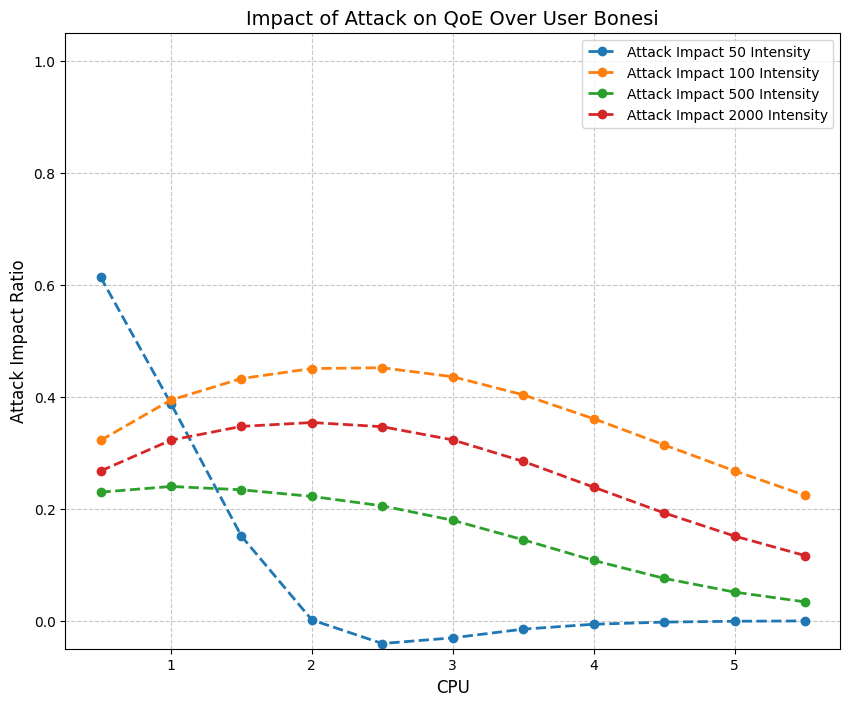

In [ ]:
# Dictionary to store different attack impact data and labels
attack_impact_data = {
    "50": [1 - qoe_fit_attack_50[i] / qoe_fit_normal[i] for i in range(len(qoe_fit_normal))],
    "100": [1 - qoe_fit_attack_100[i] / qoe_fit_normal[i] for i in range(len(qoe_fit_normal))],
    "500": [1 - qoe_fit_attack_500[i] / qoe_fit_normal[i] for i in range(len(qoe_fit_normal))],
    "2000": [1 - qoe_fit_attack_2000[i] / qoe_fit_normal[i] for i in range(len(qoe_fit_normal))]
}

mean_attack_impact_data = {
    "50": [
        1 - mean_qoe_dict["50"].loc[mean_qoe_dict["50"]["cpu"] == cpu, "qoe"].values[0] / 
            mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].values[0]
        if not mean_qoe_dict["50"].loc[mean_qoe_dict["50"]["cpu"] == cpu, "qoe"].empty and
           not mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].empty
        else None
        for cpu in mean_qoe_dict["100"]["cpu"]
    ],
    "100": [
        1 - mean_qoe_dict["100"].loc[mean_qoe_dict["100"]["cpu"] == cpu, "qoe"].values[0] / 
            mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].values[0]
        if not mean_qoe_dict["100"].loc[mean_qoe_dict["100"]["cpu"] == cpu, "qoe"].empty and
           not mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].empty
        else None
        for cpu in mean_qoe_dict["100"]["cpu"]
    ],

    "500": [
        1 - mean_qoe_dict["500"].loc[mean_qoe_dict["500"]["cpu"] == cpu, "qoe"].values[0] / 
            mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].values[0]
        if not mean_qoe_dict["500"].loc[mean_qoe_dict["500"]["cpu"] == cpu, "qoe"].empty and
           not mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].empty
        else None
        for cpu in mean_qoe_dict["500"]["cpu"]
    ],

    "2000": [
        1 - mean_qoe_dict["2000"].loc[mean_qoe_dict["2000"]["cpu"] == cpu, "qoe"].values[0] / 
            mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].values[0]
        if not mean_qoe_dict["2000"].loc[mean_qoe_dict["2000"]["cpu"] == cpu, "qoe"].empty and
           not mean_qoe_dict["0"].loc[mean_qoe_dict["0"]["cpu"] == cpu, "qoe"].empty
        else None
        for cpu in mean_qoe_dict["2000"]["cpu"]
    ]
}

# Plot settings
plt.figure(figsize=(10, 8))
x_values = np.arange(0.5, CPU_cap, 0.5)

# Iterate over attack impact data to create each plot line
for intensity, impact in attack_impact_data.items():
    plt.plot(x_values, impact, linestyle='--', marker='o', linewidth=2, label=f'Attack Impact {intensity} Intensity')
# for intensity, impact in mean_attack_impact_data.items():
#     plt.plot([cpu for cpu in mean_qoe_dict[f"{intensity}"]["cpu"]], impact, linestyle='--', marker='o', linewidth=2, label=f'Attack Impact {intensity} Intensity')

# Axis labels, title, and legend
plt.xlabel('CPU', fontsize=12)
plt.ylabel('Attack Impact Ratio', fontsize=12)
plt.title('Impact of Attack on QoE Over User Bonesi', fontsize=14)
plt.legend()

# Y-axis limits and grid
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [ ]:
mean_qoe_dict["500"]

,cpu,qoe
0,0.5,0.000000
1,1.0,0.205632
2,1.5,0.521063
3,2.0,0.722662
4,2.5,0.645747
5,3.0,0.756369
6,4.0,0.675388
7,5.0,0.863681
8,5.5,0.869136


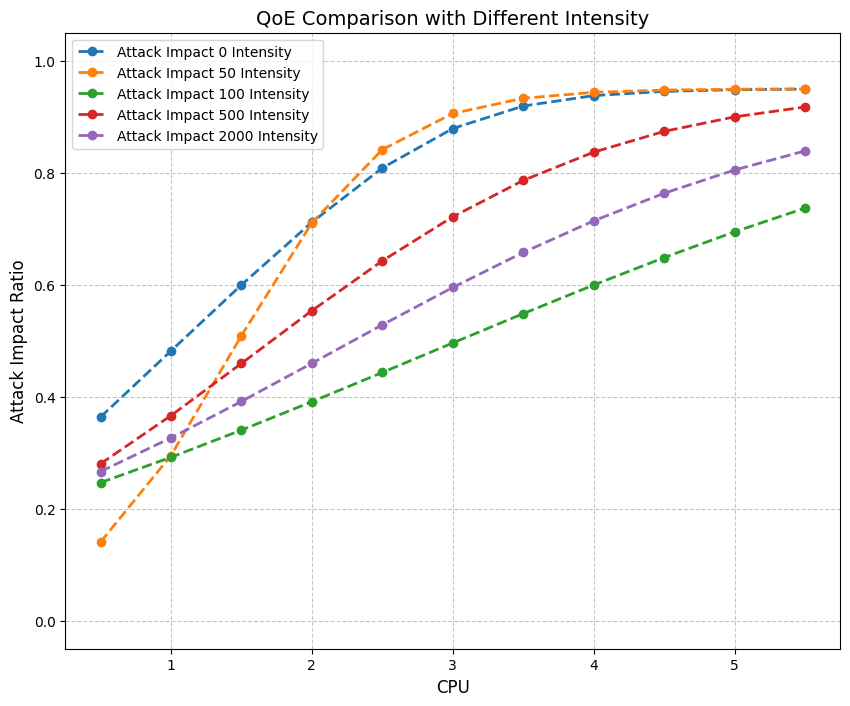

In [ ]:
attack_impact_data = {
    "0": [qoe_fit_normal[i] for i in range(len(qoe_fit_normal))],
    "50": [qoe_fit_attack_50[i] for i in range(len(qoe_fit_attack_50))],
    "100": [qoe_fit_attack_100[i] for i in range(len(qoe_fit_attack_100))],
    "500": [qoe_fit_attack_500[i]  for i in range(len(qoe_fit_attack_500))],
    "2000": [qoe_fit_attack_2000[i] for i in range(len(qoe_fit_attack_2000))]
}
# Plot settings
plt.figure(figsize=(10, 8))
x_values = np.arange(0.5, CPU_cap, 0.5)

# Iterate over attack impact data to create each plot line
for intensity, impact in attack_impact_data.items():
    plt.plot(x_values, impact, linestyle='--', marker='o', linewidth=2, label=f'Attack Impact {intensity} Intensity')

# Axis labels, title, and legend
plt.xlabel('CPU', fontsize=12)
plt.ylabel('Attack Impact Ratio', fontsize=12)
plt.title('QoE Comparison with Different Intensity', fontsize=14)
plt.legend()

# Y-axis limits and grid
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [ ]:
print("[", end="")
for impact in attack_impact_data["0"]:
    print(f"{impact:.4f}, ", end="")
print("]")

[0.2306, 0.4566, 0.6878, 0.8557, 0.9265, 0.9450, 0.9490, 0.9498, 0.9500, 0.9500, 0.9500, ]


# Attack Impact Regression

### Hand Drawn Plot

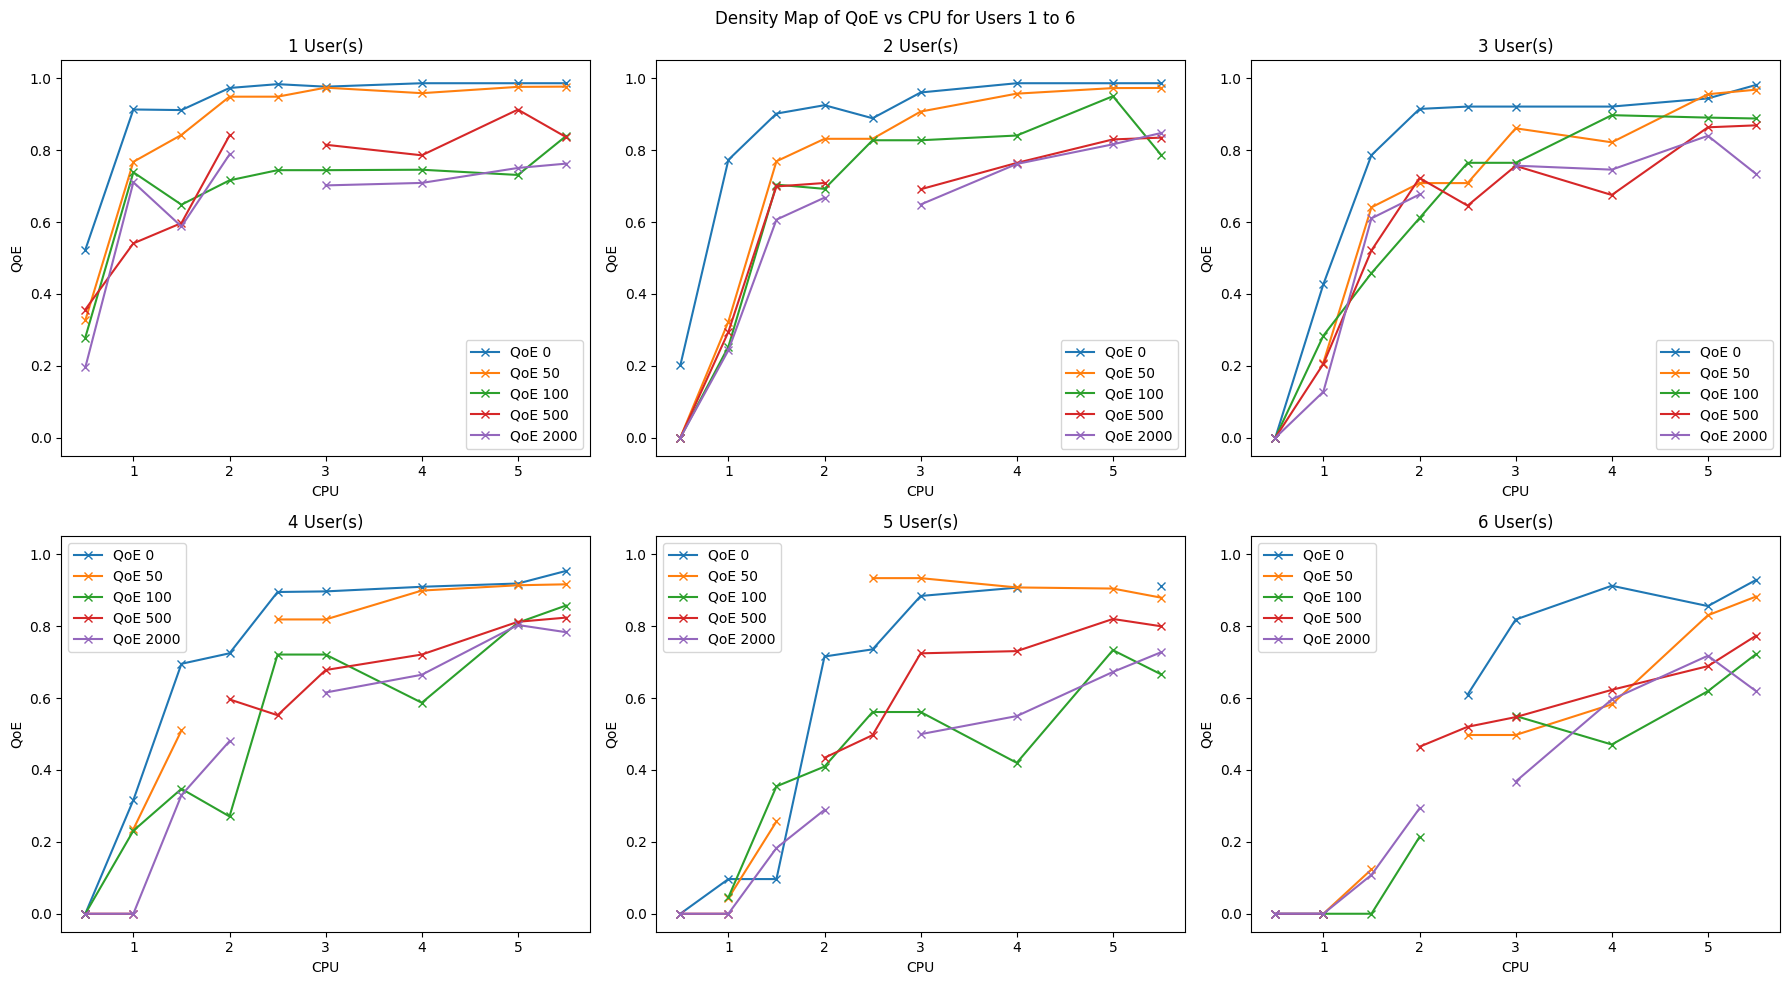

In [ ]:
# Load the data
hd_mean_df = pd.read_csv("hd_mean.csv")
hd_mean_df_grouped = hd_mean_df.groupby("intensity")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Density Map of QoE vs CPU for Users 1 to 6')
# Iterate over each group and plot all columns in `group_transposed` on the same axis
n_users=6

for n_user in range(n_users):
    # Determine the subplot location
    ax = axes[(n_user) // 3, (n_user) % 3]
    
    # Loop through each intensity group and plot
    for intensity, group in hd_mean_df_grouped:
        # Process the group: drop 'intensity' column, reset index, transpose
        group_processed = group.drop(columns=["intensity"]).reset_index(drop=True)
        group_transposed = group_processed.T
        group_transposed.index = pd.to_numeric(group_transposed.index, errors='coerce')
        
        # Plot QoE for the current user count `n_user`
        ax.plot(group_transposed.index, group_transposed[n_user], marker="x", label=f"QoE {intensity}")
    
    # Set labels and title for each subplot
    ax.set_xlabel('CPU')
    ax.set_ylabel('QoE')
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f'{n_user + 1} User(s)')  # Title based on 1-indexed user count
    ax.legend()

plt.tight_layout()
plt.show()

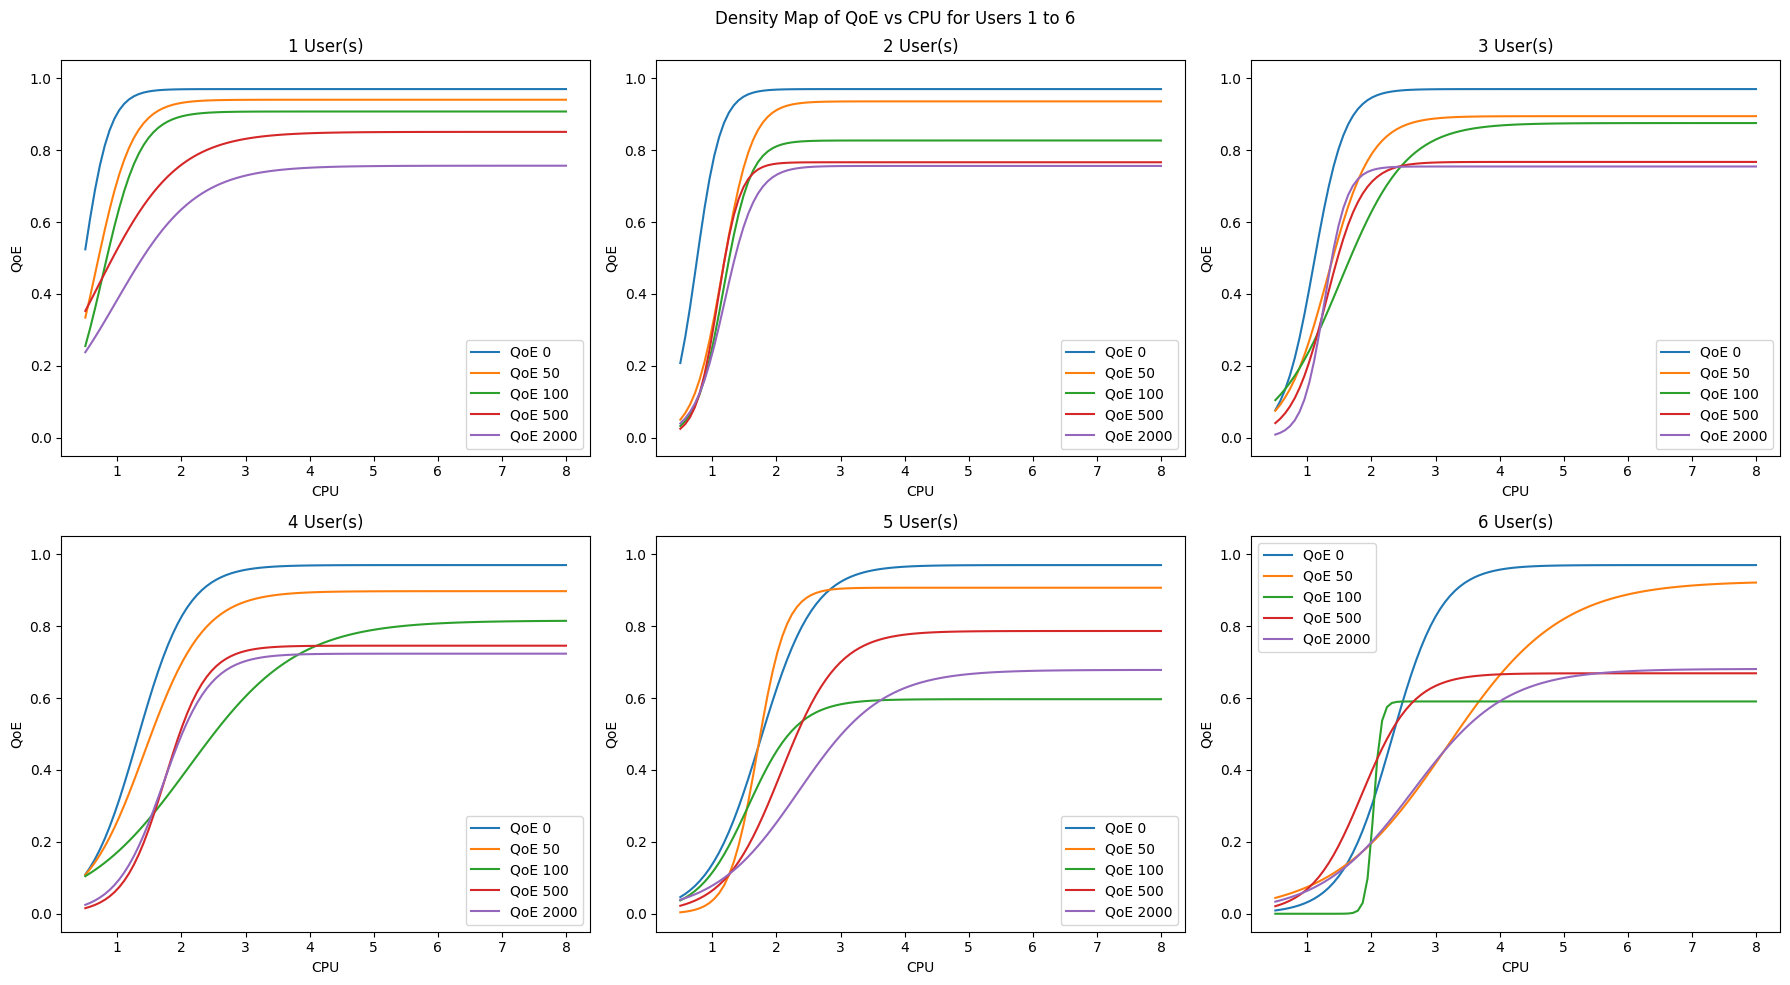

In [ ]:
def logistic(X, L, beta_0, beta_CPU):
    return L / (1 + np.exp(-(beta_0 + beta_CPU * X)))
# Load the data
hd_logistic_df = pd.read_csv("hd_logistic_fit_params.csv")
hd_logistic_df_grouped = hd_logistic_df.groupby("intensity")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Density Map of QoE vs CPU for Users 1 to 6')
# Iterate over each group and plot all columns in `group_transposed` on the same axis
n_users=6
cpu_fit = np.linspace(0.5,8.0,100)
for n_user in range(n_users):
    # Determine the subplot location
    ax = axes[(n_user) // 3, (n_user) % 3]
    
    # Loop through each intensity group and plot
    for intensity, group in hd_logistic_df_grouped:
        # Process the group: drop 'intensity' column, reset index, transpose
        group_processed = group.drop(columns=["intensity"]).reset_index(drop=True)
        group_processed.index = pd.to_numeric(group_processed.index, errors='coerce')
        group_processed.drop(columns=["n_user"], inplace=True)
        qoe_fit = logistic(cpu_fit,*group_processed.values[n_user])
        # Plot QoE for the current user count `n_user`
        ax.plot(cpu_fit, qoe_fit, label=f"QoE {intensity}")
    
    # Set labels and title for each subplot
    ax.set_xlabel('CPU')
    ax.set_ylabel('QoE')
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f'{n_user + 1} User(s)')  # Title based on 1-indexed user count
    ax.legend()

plt.tight_layout()
plt.show()

Simulate

0.97 -2.27 4.8802
0.8627183797896314 -2.4708488889711644 4.340451790772535
0.7791673699606272 -2.6272701609809292 3.920095462764797
0.6634215289681495 -2.8439654674163304 3.3377626244024365
0.5248112243325909 -3.1034668212495 2.6403956051421753
0.4882679042945565 -3.1718819441248303 2.456541264472469
0.4850220189659348 -3.177958776863776 2.4402107803686137
0.48500000000673565 -3.1779999999873896 2.440100000033888


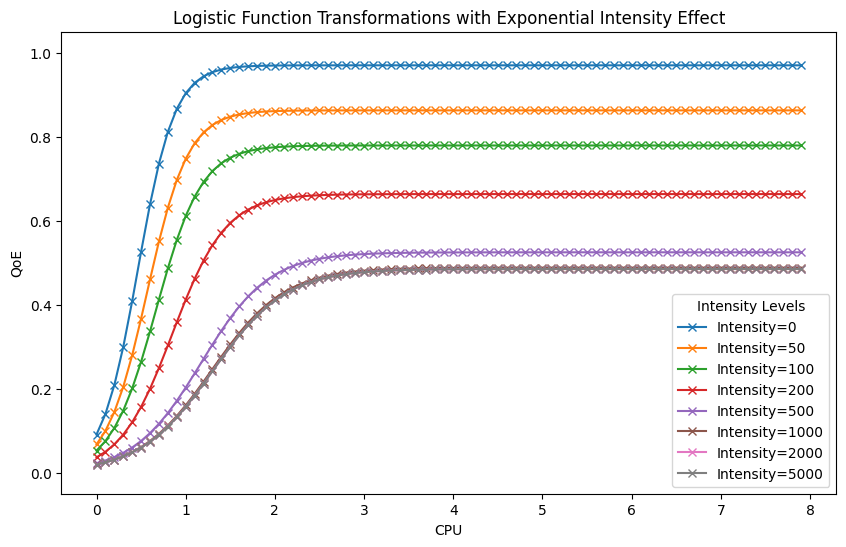

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Define the modified logistic function with exponential effect from intensity
def logistic(x, intensity, L_base=0.97, k=1.0, beta_0=-2.27, beta_CPU_base=4.8802, alpha=0.005): #Follow The Regression Params from 0 Intensity
    # Define exponential saturation adjustment for intensity effect
    intensity_effect = 1 - np.exp(-alpha * intensity)
    
    # Adjust parameters based on intensity effect
    L = L_base * (1 - 0.5 * intensity_effect)  # Decrease L with intensity effect (saturates at ~0.5*L_base)
    beta_0 = beta_0 * (1 + 0.4 * intensity_effect)  # Decrease beta_CPU similarly
    beta_CPU = beta_CPU_base * (1 - 0.5 * intensity_effect)  # Decrease beta_CPU similarly
    print(L, beta_0, beta_CPU)
    return L / (1 + np.exp(-(beta_0 + beta_CPU * x)))

# Define the x values
x_values = np.arange(0, 8.0, 0.1)

# Define intensity levels for each curve (including high levels close to saturation)
intensity_levels = [0, 50, 100, 200, 500, 1000, 2000, 5000]  # Increasing intensity up to saturation point

# Plot each curve with different intensity levels
plt.figure(figsize=(10, 6))
for intensity in intensity_levels:
    y_values = logistic(x_values, intensity)
    plt.plot(x_values, y_values, marker="x", label=f"Intensity={intensity}")

plt.xlabel("CPU")
plt.ylabel("QoE")
plt.title("Logistic Function Transformations with Exponential Intensity Effect")
plt.legend(title="Intensity Levels")
plt.ylim(-0.05, 1.05)
plt.show()

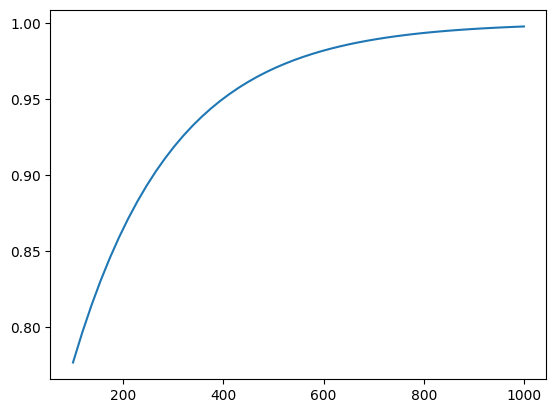

In [97]:
alpha = 0.005
X = np.linspace(1000,100)
plt.plot(X, 1 - np.exp(-alpha * (X+200)))

### Method 2: Parameter Transformation

Mean

{'2000': array([ 0.8       ,  0.43075681,  0.11397668,  0.6501534 ,  0.        ,
        -0.49550448,  0.        ]),
 '500': array([ 8.00000000e-01,  3.29795019e-04,  2.40000957e-01,  9.23856915e-01,
         2.65749828e-16, -5.67223078e-01,  0.00000000e+00]),
 '100': array([ 0.8       ,  0.9999897 , -4.17539129,  0.59285044,  0.        ,
         0.83830701,  0.        ]),
 '50': array([ 8.00000000e-01,  7.15465336e-01, -1.84805108e+00,  1.97416144e+00,
         3.20368037e-15, -3.20741027e-01,  0.00000000e+00]),
 '0': array([ 8.00000000e-01,  2.36245459e-06,  2.61522368e+00,  1.96844116e+00,
         1.61864286e-14, -1.50910598e+00,  0.00000000e+00])}

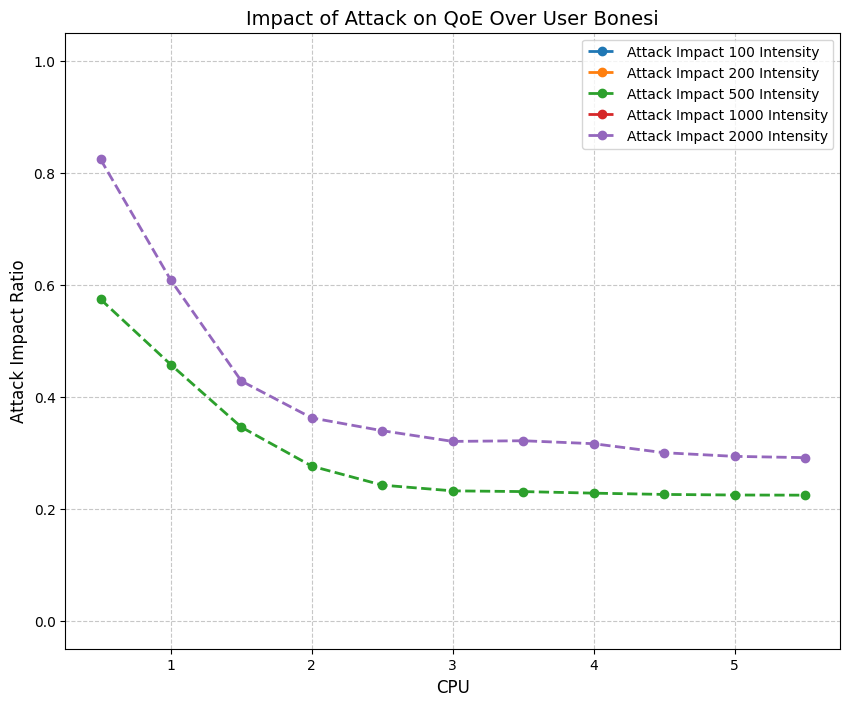

In [ ]:
# Dictionary to store different attack impact data and labels
drawn_attack_impact = {
    "100": [],
    "200":  [],
    "500":  [0.5741, 0.4571, 0.3456, 0.2760, 0.2421, 0.2319, 0.2306, 0.2278, 0.2255, 0.2245, 0.2242],
    "1000":  [],
    "2000": [0.8240, 0.6078, 0.4279, 0.3621, 0.3393, 0.3202, 0.3214, 0.3161, 0.3000, 0.2935, 0.2912],
    # "3000": [0.7539, 0.5576, 0.4076, 0.3257, 0.2802, 0.2683, 0.2726, 0.2810, 0.2720, 0.2849, 0.2991],
}

# Plot settings
plt.figure(figsize=(10, 8))
x_values = np.arange(0.5, 6.0, 0.5)

# Iterate over attack impact data to create each plot line
for intensity, impact in drawn_attack_impact.items():
    plt.plot(np.arange(0.5,(len(impact)+1)*0.5, 0.5), impact, linestyle='--', marker='o', linewidth=2, label=f'Attack Impact {intensity} Intensity')

# Axis labels, title, and legend
plt.xlabel('CPU', fontsize=12)
plt.ylabel('Attack Impact Ratio', fontsize=12)
plt.title('Impact of Attack on QoE Over User Bonesi', fontsize=14)
plt.legend()

# Y-axis limits and grid
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

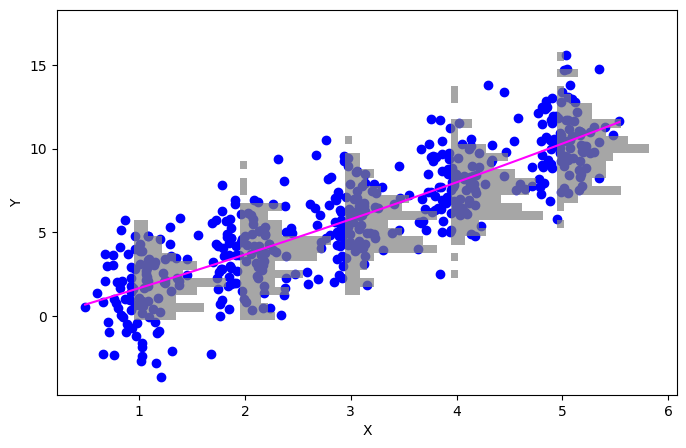

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Generate some example data
np.random.seed(0)
x = np.repeat([1, 2, 3, 4, 5], 100) + np.random.normal(0, 0.2, 500)
y = 2 * x + np.random.normal(0, 2, 500)

# Fit a curve (e.g., quadratic)
def model(x, a, b, c):
    return a * x ** 2 + b * x + c

params, _ = curve_fit(model, x, y)
x_fit = np.linspace(min(x), max(x), 100)
y_fit = model(x_fit, *params)

# Create the main scatter plot with the fitted curve
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(x, y, label="Data", color="blue")
ax.plot(x_fit, y_fit, color="magenta", label="Fit")

# Create horizontal histograms on the y-axis with shorter bars
bin_edges = np.arange(0, 18, 0.5)
for i, xpos in enumerate([1, 2, 3, 4, 5]):
    y_hist = y[(x > xpos - 0.5) & (x < xpos + 0.5)]
    hist, _ = np.histogram(y_hist, bins=bin_edges)
    ax.barh(bin_edges[:-1], hist/15, height=0.5, left=xpos - 0.05, color="gray", alpha=0.7)  # Set width to shorten the bars

# Label and show
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()


In [ ]:
hist/2

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,
       0.5, 1.5, 4.5, 2.5, 3.5, 3.5, 4. , 6.5, 5. , 3.5, 4.5, 2.5, 2.5,
       1. , 0.5, 0. , 1.5, 0. , 0.5, 0. , 0. , 0. ])

In [ ]:
debug_csv = pd.read_csv("./150_qoe_atk500_noids.csv")
debug_csv['scaled_qoe'] = scaled_atk_qoe_df['qoe']
debug_csv.to_csv('debug.csv', index=False)
scaled_atk_qoe_df.to_csv('scaled_debug.csv', index=False)

### Calculating QoE

In [ ]:
def calculate_qoe(initial_startup_delay, bitrate, buffer_length, stall_count, stall_duration, client_id):
    
    if not (bitrate and buffer_length and stall_count and stall_duration):
        return None
    sampling_rate = 2.0
    # Calculate the Video Resolution 
    bitrate_arr = np.array(bitrate)[:,1]
    integrated_resolution = np.trapz(bitrate_arr, dx = sampling_rate)
    video_resolution = 1/(len(bitrate_arr)*sampling_rate)*integrated_resolution
    # Calculate Video Variation Rate
    bitrate_diff_arr = np.square(np.diff(bitrate_arr))
    integrated_variation_rate = np.trapz(bitrate_diff_arr, dx = sampling_rate)
    variation_rate = 1/(len(bitrate_diff_arr)*sampling_rate)*integrated_variation_rate
    # Get Initial Startup Delay
    initial_startup_delay = initial_startup_delay
    # Calculate Video Stalling
    stall_duration_arr = np.array(stall_duration)[:,1]
    stall_diff_arr = np.diff(stall_duration_arr) if len(stall_duration_arr) > 1 else stall_duration
    total_stall_duration = np.sum(stall_diff_arr) 
    
    # TODO: Normalize using Standard Normalization, when collecting data, record it in a csv and then get the mean and variance
    qoe = video_resolution - variation_rate - initial_startup_delay - total_stall_duration
    
    # TODO: Decide on the weight
    w_resolution = 0.2
    w_variation = 0.15
    w_startup_delay = 0.4
    w_stalling = 0.25    
    # Store the results in a DataFrame for easy output
    qoe_df = pd.DataFrame({
        'client_id': [client_id],
        'video_resolution': [video_resolution],
        'variation_rate': [variation_rate],
        'startup_delay': [initial_startup_delay],
        'total_stall_duration': [total_stall_duration],
        'time':[int(bitrate[-1][0])],
        f'qoe_{client_id}': [qoe]
    })    
    
    # ? Record QoE Data
    file_path = 'qoe_data.csv'
    # write_or_append_csv(file_path, qoe_df)
    return qoe_df

In [ ]:
data['load'][0]['duration']

NameError: name 'data' is not defined

In [ ]:
client_id = 0
qoe_df = pd.DataFrame({
    'client_id': [client_id],
    'video_resolution': [None],
    'variation_rate': [None],
    'startup_delay': [None],
    'avg_stall_duration': [None],
    f'qoe_{client_id}': [None]
})            

# Result Analysis and Plot

In [ ]:
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
qoe_df = pd.read_csv("qoe_data_hls_resourcevsuser.csv")
cpu = qoe_df['cpu'].copy()
user = qoe_df['user'].copy()
qoe_df.drop(columns=["client_id", "qoe_0", "watch_time", 'cpu', 'user'], inplace=True)
qoe_df.head(3)
qoe_df['video_resolution'].apply()

,video_resolution,variation_rate,startup_delay,avg_stall_duration
0,822.878622,469046.277017,5618.3,0.020947
1,1004.270996,122471.888291,7746.4,0.109389
2,977.166436,68127.359371,5817.4,0.000000


In [ ]:
scaler = MinMaxScaler()
scaled_qoe_df = scaler.fit_transform(qoe_df)
scaled_qoe_df = pd.DataFrame(scaled_qoe_df, columns=qoe_df.columns)
scaled_qoe_df['cpu'] = cpu
scaled_qoe_df['user'] = user
scaled_qoe_df['qoe'] = scaled_qoe_df['video_resolution'] - 0.25*scaled_qoe_df['variation_rate'] - 0.25*scaled_qoe_df['startup_delay'] - 0.25*scaled_qoe_df['avg_stall_duration']
scaled_qoe_df.head(3)


,video_resolution,variation_rate,startup_delay,avg_stall_duration,cpu,user,qoe
0,0.731448,0.842370,0.725279,0.020947,2500,1,0.334299
1,0.892685,0.219950,1.000000,0.109389,2500,1,0.560351
2,0.868592,0.122351,0.750981,0.000000,2500,1,0.650259


<Axes: title={'center': 'QoE vs CPU by User'}, xlabel='cpu', ylabel='qoe'>

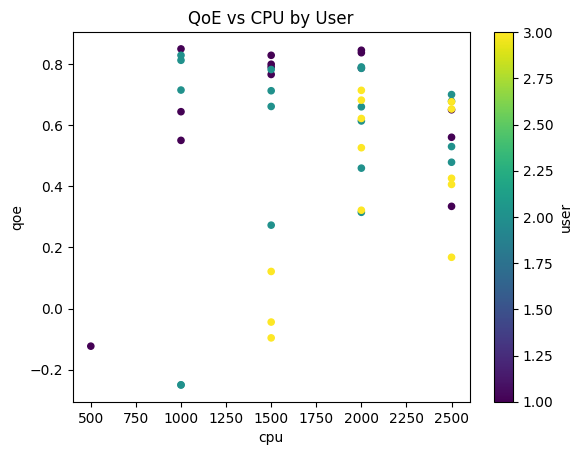

In [ ]:
scaled_qoe_df.plot.scatter(x='cpu', 
                           y='qoe', 
                           c='user', 
                           colormap='viridis',  # Change the colormap if desired
                           colorbar=True, 
                           title='QoE vs CPU by User')

# CPU vs Detection Speed

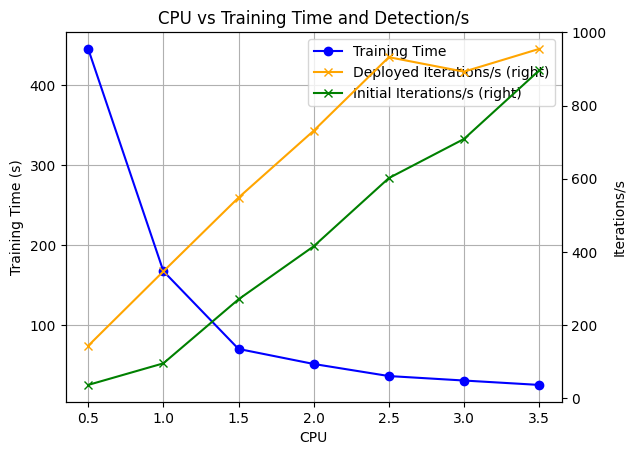

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
cpu_df = pd.read_csv('experiment_data/cpu_vs_detection_speed.csv')
ax = cpu_df.plot(x='CPU', y='Training Time', kind='line', color='blue', marker='o')
ax.set_ylabel('Training Time (s)')
ax2 = cpu_df.plot(x='CPU', y='Deployed Iterations/s', kind='line', color='orange', secondary_y=True, ax=ax, marker='x')
ax2.set_ylabel('Iterations/s')
ax3 = cpu_df.plot(x='CPU', y='Initial Iterations/s', kind='line', marker='x', color='green', secondary_y=True, ax=ax)
ax.set_title('CPU vs Training Time and Detection/s')
ax.grid(linestyle='-')
plt.show()
